# SmartCrop refactor - Actor model


Author: Jacob A Rose  
Created on: Thursday August 19th, 2021

## Top

### Imports

In [1]:

import logging
from tqdm.auto import tqdm, trange
from typing import Callable, Optional, Union, List, Tuple
from torchvision.datasets import ImageFolder
import torch
import os
# import pandas as pd

from pathlib import Path
import random
from rich import print as pp
seed = 334455

import numpy as np
from PIL import Image, ImageStat
import PIL
import cv2


random.seed(seed)
np.random.seed(seed)
from torchvision import transforms
from torchvision import utils
import torchvision
from torch import nn
from lightning_hydra_classifiers.utils.ResizeRight.resize_right import resize_right, interp_methods
# from ResizeRight.resize_right import resize_right, interp_methods
from functools import partial
# from pandarallel import pandarallel
# tqdm.pandas()

import ray
import modin.pandas as pd
from tqdm import tqdm
from modin.config import ProgressBar
ProgressBar.enable()
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.cache_size = 0
# InteractiveShell.ast_node_interactivity = "all"

from dataclasses import dataclass, asdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

In [2]:
# for res in [256,512]:
#     print(f'Testing resolution: {res}')
#     test = test_CleverCrop(res=res)
#     test.run()



# def aspect_ratio(img: torch.Tensor):

#     minside = np.min(img.shape[1:])
#     maxside = np.max(img.shape[1:])

#     aspect_ratio = (maxside / minside)
#     return aspect_ratio


# img.shape
# img.transpose(2,0,1).shape
# img.shape

# import cv2
# root = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg/Ulmaceae"
# paths = [os.path.join(root, p) for p in os.listdir(root)]
# print(f'Calculating shape of {len(paths)} images')

# shapes = []
# for p in paths:
#     img = cv2.imread(p)
#     img = img.transpose(2,0,1)
    
#     if img.shape[1] > img.shape[2]:
#         shapes.append((p, img.shape, aspect_ratio(img)))
#         print(f'Saving {shapes[-1]}')
# pp(shapes)

### Catalog functions

In [3]:
# from torchvision.datasets import ImageFolder
# # def get_image_dataset(root_dir):
# #     """
# #     Simple wrapper around torchvision.datasets.ImageFolder
# #     """
# #     dataset = ImageFolder(root_dir)
# #     return dataset

# ##################
# ##################


# from typing import *
# import sys
# import argparse

# class DatasetFilePathParser:
    
#     @classmethod
#     def get_parser(cls, dataset_name: str) -> Dict[str, Callable]:
#         if "Extant_Leaves" in dataset_name:
#             return cls().ExtantLeavesParser
#         if "Fossil" in dataset_name:
#             return cls().FossilParser
#         if "PNAS" in dataset_name:
#             return cls().PNASParser
    
# #     @property
#     @classmethod
#     def parse_dtypes(self, data: pd.DataFrame) -> pd.DataFrame:
#         return data.astype({
#                             "path": pd.StringDtype(),
#                             "family": pd.CategoricalDtype(),
#                             "genus": pd.CategoricalDtype(),
#                             "species": pd.CategoricalDtype(),
#                             "catalog_number": pd.StringDtype(),
#                             "relative_path": pd.StringDtype(),
#                             "root_dir": pd.CategoricalDtype()
#                            })
    
#     @property
#     def ExtantLeavesParser(self):
#         return {
#                 "family": lambda x, col: Path(x[col]).stem.split('_')[0],
#                 "genus": lambda x, col: Path(x[col]).stem.split('_')[1],
#                 "species": lambda x, col: Path(x[col]).stem.split('_')[2],
#                 "catalog_number": lambda x, col: Path(x[col]).stem.split('_', maxsplit=4)[-1],
#                 "relative_path": lambda x, col: str(Path(x[col]).relative_to(root_dir)),
#                 "root_dir": lambda x, col:  str(Path(x[col]).parent.parent)
#                }

#     @property
#     def FossilParser(self):
#         return {
#                 "family": lambda x, col: Path(x[col]).stem.split('_')[0],
#                 "genus": lambda x, col: Path(x[col]).stem.split('_')[1],
#                 "species": lambda x, col: Path(x[col]).stem.split('_')[2],
#                 "catalog_number": lambda x, col: Path(x[col]).stem.split('_', maxsplit=4)[-1],
#                 "relative_path": lambda x, col: str(Path(x[col]).relative_to(root_dir)),
#                 "root_dir": lambda x, col:  str(Path(x[col]).parent.parent)
#                }


#     @property
#     def PNASParser(self):
#         return {
#                 "family": lambda x, col: Path(x[col]).stem.split('_')[0],
#                 "genus": lambda x, col: Path(x[col]).stem.split('_')[1],
#                 "species": lambda x, col: Path(x[col]).stem.split('_')[2],
#                 "catalog_number": lambda x, col: Path(x[col]).stem.split('_', maxsplit=3)[-1],
#                 "relative_path": lambda x, col: str(Path(x[col]).relative_to(root_dir)),
#                 "root_dir": lambda x, col:  str(Path(x[col]).parent.parent)
#                }

    
    
# def parse_df_catalog_from_image_directory(root_dir: str, dataset_name: str="Extant_Leaves") -> pd.DataFrame:
#     """
#     Crawls root_dir and collects absolute paths of any images into a dataframe. Then, extracts
#     maximum available metadata from file paths (e.g. family, species labels in file name).
    
#     Arguments:
    
#         root_dir (str):
#             Location of the Imagenet-format organized image data on disk
#     Returns:
#         data_df (pd.DataFrame):
            
            
#     """
    
#     parser = DatasetFilePathParser.get_parser(dataset_name)
#     data_df = Extract.df_from_dir(root_dir)['all']
#     for col, func in parser.items():
#         print(col)
#         data_df = data_df.assign(**{col:data_df.apply(lambda x: func(x, "path"), axis=1)})
        
#     data_df = DatasetFilePathParser.parse_dtypes(data_df)
#     return data_df
    

In [4]:
# # Stack into one large dask.array
# stack = da.stack(dask_arrays, axis=0)
# stack.shape  # (nfiles, nz, ny, nx)

# # in jupyter notebook the repr of a dask stack provides a useful visual:
# stack



# dataset_stem = dataset_name
# if "Fossil" in dataset_stem:
#     dataset_stem = f"Fossil/{dataset_stem}"
# data_db_root_dir = Path("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images")
# root_dir = str(data_db_root_dir / dataset_stem / "original" / "full" / "jpg")

# from lightning_hydra_classifiers.utils.dataset_management_utils import Extract# as ExtractBase
# from lightning_hydra_classifiers.data.utils.catalog_registry import *
# dataset_tag = f"{dataset_name}_family_100"
# root_dir = available_datasets.get_latest(dataset_tag)
# print(f'root_dir = {root_dir}')
# data_df = parse_df_catalog_from_image_directory(root_dir=root_dir, dataset_name=dataset_name)
# data_df



### clevercrop

In [5]:
import json
totensor: Callable = torchvision.transforms.ToTensor()
    
def toPIL(img: torch.Tensor, mode="RGB") -> Callable:
    return torchvision.transforms.ToPILImage(mode)(img)


class NormalizeImage(nn.Module):
    
    @staticmethod
    def channelwise_min(img: torch.Tensor) -> torch.Tensor:
        return img.min(dim=1).values.min(dim=1).values

    @staticmethod
    def channelwise_max(img: torch.Tensor) -> torch.Tensor:
        return img.max(dim=1).values.max(dim=1).values

    @staticmethod
    def normalize_image(img: torch.Tensor) -> torch.Tensor:
        """Enforce pixel bounds to range [0.0, 1.0]"""
        img_min = NormalizeImage.channelwise_min(img).view(-1,1,1)
        img_max = NormalizeImage.channelwise_max(img).view(-1,1,1)
        return ((img - img_min) / (img_max - img_min))

########################
########################

@dataclass
class CleverCropConfig:
    
    interp_method: Callable=interp_methods.cubic
    antialiasing: bool=True
    target_shape: Tuple[int]=(3, 128, 128)
    max_aspect_ratio: float=1.2
    grayscale: bool=False
    normalize: bool=True
    

class CleverCrop:
    
    def __init__(self,
                 interp_method=interp_methods.cubic,
                 antialiasing=True,
                 target_shape: Tuple[int]=(3, 128, 128),
                 max_aspect_ratio: float=1.2,
                 grayscale: bool=False,
                 normalize: bool=True
                ):
        """[summary]

        Args:
            interp_method: Defaults to interp_methods.cubic.
            antialiasing (bool): Defaults to True.
            target_shape (Tuple[int], optional): [description]. Defaults to (3,128,128).
            grayscale (bool, optional): [description]. Defaults to False.
            max_aspect_ratio (float): Defaults to 1.2
            normalize (bool): Defaults to True
                If True, normalize final image tensor to the range [0.0, 1.0]

        """

        self.interp_method=interp_method
        self.antialiasing=antialiasing
        self.target_shape=target_shape
        self.num_output_channels = self.target_shape[0]
        self.max_aspect_ratio=max_aspect_ratio
        self.grayscale=grayscale
        self.normalize=normalize
        
        self.resize = partial(resize_right.resize,
#                               out_shape=self.target_shape,
                              interp_method=self.interp_method,
                              antialiasing=self.antialiasing)
        self.normalize_image = NormalizeImage.normalize_image
        
        print('CleverCrop.__init__() ->', repr(self))

    
    @staticmethod
    def aspect_ratio(img: torch.Tensor):
        
        minside = np.min(img.shape[1:])
        maxside = np.max(img.shape[1:])

        aspect_ratio = (maxside / minside)
        return aspect_ratio
        
        
    def __call__(self,
                 img: torch.Tensor,
                 target_shape: Optional[Tuple[int]]=None
                ) -> torch.Tensor:
        """[summary]

        Args:
            img (torch.Tensor): [description]
            target_shape: (Optional[Tuple[int]]): Optionally override this CleverCrop class instance's init value.

        Returns:
            torch.Tensor: [description]
        """
        target_shape = target_shape or self.target_shape

        minside = np.min(img.shape[1:])# + 1
        maxside = np.max(img.shape[1:])# + 1
        new_img = img

        aspect_ratio = (maxside / minside)
        if aspect_ratio > self.max_aspect_ratio:
#             print(f'Aspect Ratio = {aspect_ratio:.2f} > max_aspect_ratio = {self.max_aspect_ratio}, stacking.')
            num_repeats = np.floor((maxside / minside)) 
            min_dim = np.argmin(img.shape[1:]) + 1
            for _ in range(int(num_repeats)):
                new_img = torch.cat([new_img, img], dim=min_dim)
        if maxside == img.shape[2]:
#             print(f'maxside = {maxside} is width, rotating.')
            new_img = torch.rot90(new_img, k=1, dims=[1,2])

        new_img = self.resize(new_img, out_shape=target_shape)

        if self.grayscale:
            num_output_channels = self.target_shape[0]
            new_img = torchvision.transforms.functional.rgb_to_grayscale(img=new_img,
                                                                         num_output_channels=self.num_output_channels)

        if self.normalize:
            new_img = self.normalize_image(new_img)

        return new_img

    def __repr__(self):
        return json.dumps({
        "interp_method":str(self.interp_method),
        "antialiasing":self.antialiasing,
        "target_shape":self.target_shape,
        "num_output_channels":self.num_output_channels,
        "max_aspect_ratio":self.max_aspect_ratio,
        "grayscale":self.grayscale,
        "normalize":self.normalize})
    
    
    

os.environ['TEST_IMAGES'] ="/media/data/jacob/GitHub/lightning-hydra-classifiers/tests/test_images/"
    
    
class test_CleverCrop:
    
    test_data_dir: str = os.getenv('TEST_IMAGES')
    tall_img_path: str = os.path.join(test_data_dir, "tall_aspect_ratio_leaf_image.jpg")
    wide_img_path: str = os.path.join(test_data_dir, "wide_aspect_ratio_leaf_image.jpg")
    
    def __init__(self, res=256):
        self.seed = 333333
        self.target_shape=(3, res, res)
        self.tall_img = totensor(PIL.Image.open(self.tall_img_path))
        self.wide_img = totensor(PIL.Image.open(self.wide_img_path))
        
        self.config = CleverCropConfig(interp_method=interp_methods.cubic,
                                       antialiasing=True,
                                       target_shape=self.target_shape,
                                       max_aspect_ratio=1.2,
                                       grayscale=False,
                                       normalize=True)
        
    def run(self):
        transform = CleverCrop(**asdict(self.config))
        
        tall_cropped = transform(self.tall_img)
        wide_cropped = transform(self.wide_img)

        print('Tall:')
        print(f'Input shape: {self.tall_img.shape}')
        print(f'Output shape: {tall_cropped.shape}')
        
        print('Wide:')
        print(f'Input shape: {self.wide_img.shape}')
        print(f'Output shape: {wide_cropped.shape}')
        
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(self.tall_img.permute(1,2,0))
        ax[1].imshow(tall_cropped.permute(1,2,0))

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(self.wide_img.permute(1,2,0))
        ax[1].imshow(wide_cropped.permute(1,2,0))


In [6]:
torch.rot90

<function _VariableFunctionsClass.rot90>

### Dask functions

In [7]:
def split_df_into_chunks(data_df: pd.DataFrame, num_chunks: int) -> List[pd.DataFrame]:
    idx_chunks = [list(idx) for idx in more_itertools.divide(num_chunks, range(len(data_df)))]
    df_chunks = [data_df.iloc[idx,:] for idx in idx_chunks]
    return df_chunks

####################################
####################################

# clever_crop = CleverCrop(target_shape=(3,config.resolution,config.resolution) )

####################################
####################################
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
import dask.array as da
import dask.dataframe as dd
import dask

In [8]:
# @dask.delayed
# def dask_open_pil(path: str) -> PIL.Image:
#     return Image.open(path)

# @dask.delayed
# def dask_transform(img: PIL.Image) -> torch.Tensor:
#     img = transforms.ToTensor()(img)
#     img = clever_crop(img)
#     return (img * 255.0).to(torch.uint8).numpy()
# #     return (img * 255.0).to(torch.uint8)

# @dask.delayed
# def dask_write_jpeg(img: torch.Tensor,
#                    target_path: str) -> bool:
#     if os.path.isfile(target_path):
#         return True
#     try:
#         torchvision.io.write_jpeg(img,
#                                   target_path,
#                                   quality=100)
#     except Exception as e:
#         print(target_path, e)
#     return os.path.isfile(target_path)


####################################
####################################

# @dask.delayed
# def dask_ExtractTransform(path: str):
#     img = dask_open_pil(path=path)
#     img = dask_transform(img=img)
#     return img



# @dask.delayed
# def dask_LoadTransformWrite(source_path: str,
#                            target_path: str):
#     img = dask_open_pil.remote(path=source_path)
#     img = dask_transform.remote(img=img)
#     img = dask_write_jpeg.remote(img=img,
#                                 target_path=target_path)

#     return img

#### Previous dask funcs

In [9]:
from lightning_hydra_classifiers.utils.dataset_management_utils import Extract as ExtractBase
from lightning_hydra_classifiers.utils.dataset_management_utils import DatasetFilePathParser, parse_df_catalog_from_image_directory
from typing import *
class DaskExtract(ExtractBase):
    
    
    @dask.delayed
    @staticmethod
    def dask_open_pil(path: str) -> PIL.Image:
        return Image.open(path)

    @dask.delayed
    @staticmethod
    def dask_transform(img: PIL.Image,
                       target_shape: Optional[Tuple[int]]=None
                      ) -> np.ndarray:
        img = transforms.ToTensor()(img)
        img = clever_crop(img, target_shape=target_shape)
        return (img * 255.0).to(torch.uint8).numpy()
    #     return (img * 255.0).to(torch.uint8)

    @dask.delayed
    @staticmethod
    def dask_write_jpeg(img: torch.Tensor,
                        target_path: str) -> bool:
        if os.path.isfile(target_path):
            return True
        try:
            torchvision.io.write_jpeg(img,
                                      target_path,
                                      quality=100)
        except Exception as e:
            print(target_path, e)
        return os.path.isfile(target_path)
    
    
    @dask.delayed
    @classmethod
    def ExtractTransform(cls,
                         path: str,
                         target_shape: Optional[Tuple[int]]=None
                        ) -> np.ndarray:
        img = cls.dask_open_pil(path=path)
        img = cls.dask_transform(img=img, target_shape=target_shape)
        return img

    
#     @dask.delayed
    @classmethod
    def ExtractTransformSave(cls,
                             row: Dict[str, Any],
                             target_shape: Optional[Tuple[int]]=None
                            ) -> bool:
#         img = cls.dask_open_pil(path=row["path"])
#         img = cls.dask_transform(img=img)
        
        img = cls.ExtractTransform(path=row["path"], target_shape=target_shape)
        success = cls.dask_write_jpeg(img, row["target_path"])
        return success

In [10]:
@dask.delayed
def dask_open_pil(path: str) -> PIL.Image:
    return Image.open(path)

@dask.delayed
def dask_transform(img: PIL.Image,
                   target_shape: Optional[Tuple[int]]=None
                  ) -> np.ndarray:
    img = transforms.ToTensor()(img)
    img = clever_crop(img, target_shape=target_shape)
    return (img * 255.0).to(torch.uint8).numpy()



@dask.delayed
def dask_write_jpeg(img: torch.Tensor,
                    target_path: str) -> bool:
    if os.path.isfile(target_path):
        return True
    try:
        torchvision.io.write_jpeg(img,
                                  target_path,
                                  quality=100)
    except Exception as e:
        print(target_path, e)
    return os.path.isfile(target_path)


@dask.delayed
def ExtractTransform(path: str,
                     target_shape: Optional[Tuple[int]]=None
                    ) -> np.ndarray:
    img = dask_open_pil(path=path)
    img = dask_transform(img=img, target_shape=target_shape)
    return img



def write_jpeg(img: torch.Tensor,
               target_path: str) -> bool:
    if os.path.isfile(target_path):
        return True
    try:
        torchvision.io.write_jpeg(img,
                                  target_path,
                                  quality=100)
    except Exception as e:
        print(target_path, e)
    return os.path.isfile(target_path)

@dask.delayed
def ExtractTransformSave(row: Dict[str, Any],
                         target_shape: Optional[Tuple[int]]=None
                        ) -> bool:
    
    img = Image.open(row["path"])
    img = transforms.ToTensor()(img)
    img = clever_crop(img, target_shape=target_shape)
    img = (img * 255.0).to(torch.uint8)#.numpy()

    success = write_jpeg(img, row["target_path"])
#     if success:
    print(f"Write success = {success}")
    print(f'Target: {row["target_path"]}')
#     else:
#         print('fail')
    return img.numpy()




# @dask.delayed
# def ExtractTransformSave(row: Dict[str, Any],
#                          target_shape: Optional[Tuple[int]]=None
#                         ) -> bool:
    
    
#     img = dask_open_pil(path=row["path"])
#     img = dask_transform(img=img, target_shape=target_shape)
# #     img = ExtractTransform(path=row["path"], target_shape=target_shape)
#     success = dask_write_jpeg(img, row["target_path"])
# #     if success:
#     print(f'Successful write to: {row["target_path"]}')
# #     else:
# #         print('fail')
#     return img

#### atomic-functions

In [11]:
# @dask.delayed
# def open_pil(row: Dict[str,Any]) -> PIL.Image:
#     return Image.open(row["path"])

# @dask.delayed
# def transform(img: PIL.Image,
#               row: Dict[str,Any]=None,
#               target_shape: Optional[Tuple[int]]=None
#               ) -> np.ndarray:
#     img = transforms.ToTensor()(img)
#     img = clever_crop(img, target_shape=target_shape)
#     return ((img * 255.0).to(torch.uint8).numpy(), row)



# import cv2
from skimage import io


print(io.plugin_order())

# @dask.delayed
def open_image(row: List[Dict[str,Any]]) -> np.ndarray:
#     print(len(rows))
#     print(type(row))
#     print("open_image") #, type(row), len(row))
#     if isinstance(row, list):
#         print(len(row))
#     print(type(imgs), type(rows), type(target_shape))
#     if not isinstance(row, list):
#         rows = [rows]
#         rows = rows[0]
    
#     return [io.imread(item["path"]) for item in rows]
    return io.imread(row["path"])
#     return cv2.imread(row["path"])

# @dask.delayed
def transform(img: np.ndarray,
              row: Dict[str,Any]=None,
              target_shape: Optional[Tuple[int]]=None
              ) -> np.ndarray:
#     print(type(img), type(row), type(target_shape))
#     print("transform")
#     if isinstance(img, list):
#         print(len(img))
#         imgs = [imgs]
#     if isinstance(row, list):
#         print(len(row))
#         rows = [rows]
#     return [io.imread(item["path"]) for item in row]

    img = transforms.ToTensor()(img)
    img = clever_crop(img, target_shape=target_shape)
    img = (img * 255.0).to(torch.uint8).numpy()
    img = np.moveaxis(img, 0, -1)
    return img



# @dask.delayed
def write_jpeg(img: np.ndarray,
               row: Dict[str,Any]) -> bool:
#     print("Write_jpeg")
#     print("img.shape=", img.shape)#,  "target_shape: ", target_shape)

    if os.path.isfile(row['target_path']):
        return True
    try:
        io.imsave(row['target_path'],
                  img,
                  quality=100)
        out = True
    except Exception as e:
        print("Write image error:", row['target_path'], e)
        out = False
    return out





# @dask.delayed
# def batch_ETL(batch_records, target_shape: Tuple[int]):
    
#     resize_transform = partial(transform, target_shape=target_shape)
    
#     print("Batch_ETL")
#     print(f"len(batch_records): {len(batch_records)}")
#     print(f"type(batch_records): {type(batch_records)}")
#     extracted, transformed, written = [], [], []
#     for i, rec in enumerate(batch_records):
#         extracted.append(open_image(row=rec))
#         transformed.append(resize_transform(img=extracted[-1], row=rec))
#         written.append(write_jpeg(img=transformed[-1], row=rec))
# #     break
#     print(f"Processed chunksize={i}")
#     return extracted, transformed, written


# @dask.delayed
# def batch_ETL(batch_records, target_shape: Tuple[int]):
    
#     resize_transform = partial(transform, target_shape=target_shape)
    
# #     print("Batch_ETL")
# #     print(f"len(batch_records): {len(batch_records)}")
# #     print(f"type(batch_records): {type(batch_records)}")
#     extracted, transformed, written = [], [], []
#     for i, rec in enumerate(batch_records):
#         extracted.append(dask.delayed(open_image)(row=rec))
#         transformed.append(dask.delayed(resize_transform)(img=extracted[-1], row=rec))
#         written.append(dask.delayed(write_jpeg)(img=transformed[-1], row=rec))
# #     break
#     print(f"Processed chunksize={i}")
# #     return extracted, transformed, written
#     return written


# @dask.delayed
def batch_ETL(batch_records, target_shape: Tuple[int]):
    
    resize_transform = partial(transform, target_shape=target_shape)
    
#     print("Batch_ETL")
#     print(f"len(batch_records): {len(batch_records)}")
#     print(f"type(batch_records): {type(batch_records)}")
#     extracted, transformed, written = [], [], []
    imgs = []
    for i, rec in enumerate(batch_records):
#         print(i, type(rec), len(rec))
#     for i, batch in enumerate(batch_records):
#         print(i, type(batch), len(batch))
#         for rec in batch:
#             img = dask.delayed(open_image)(row=rec)
#             img = dask.delayed(resize_transform)(img=img, row=rec)
#             img = dask.delayed(write_jpeg)(img=img, row=rec)
#             imgs.append(img)
        if os.path.isfile(rec['target_path']):
#             print(f"Skipping {i}")
            continue
        img = open_image(row=rec)
        img = resize_transform(img=img, row=rec)
        img = write_jpeg(img=img, row=rec)
    
#         img = dask.delayed(open_image)(row=rec)
#         img = dask.delayed(resize_transform)(img=img, row=rec)
#         img = dask.delayed(write_jpeg)(img=img, row=rec)
        imgs.append(img)

    print(f"Computing {len(imgs)} images, Skipping {len(batch_records) - len(imgs)}")
#     imgs = dask.persist(*imgs)
#     imgs = dask.compute(*imgs)
#     print(f"Processed chunksize={i}")
#     return extracted, transformed, written
    return imgs


    
# print(extracted, transformed, written)

{'imread': ['imageio', 'matplotlib'], 'imsave': ['imageio'], 'imshow': ['matplotlib'], 'imread_collection': ['imageio', 'matplotlib'], 'imshow_collection': ['matplotlib'], '_app_show': ['matplotlib']}


#### list-functions

In [12]:
# # @dask.delayed
# # def open_pil(row: Dict[str,Any]) -> PIL.Image:
# #     return Image.open(row["path"])

# # @dask.delayed
# # def transform(img: PIL.Image,
# #               row: Dict[str,Any]=None,
# #               target_shape: Optional[Tuple[int]]=None
# #               ) -> np.ndarray:
# #     img = transforms.ToTensor()(img)
# #     img = clever_crop(img, target_shape=target_shape)
# #     return ((img * 255.0).to(torch.uint8).numpy(), row)



# # import cv2
# from skimage import io


# print(io.plugin_order())

# # @dask.delayed
# def open_image(rows: List[Dict[str,Any]]) -> np.ndarray:
# #     print(len(rows))
# #     print(type(imgs), type(rows), type(target_shape))
#     if not isinstance(rows, list):
#         rows = [rows]
# #         rows = rows[0]
#     return [io.imread(item["path"]) for item in rows]
# #     return io.imread(row["path"])
# #     return cv2.imread(row["path"])

# # @dask.delayed
# def transform(imgs: np.ndarray,
#               rows: Dict[str,Any]=None,
#               target_shape: Optional[Tuple[int]]=None
#               ) -> np.ndarray:
#     print(type(imgs), type(rows), type(target_shape))
#     if not isinstance(imgs, list):
#         imgs = [imgs]
#     if not isinstance(rows, list):
#         rows = [rows]
# #     return [io.imread(item["path"]) for item in row]

#     out = []
    
#     for img, row in zip(imgs, rows):
#         img = transforms.ToTensor()(img)
#         img = clever_crop(img, target_shape=target_shape)
#         img = (img * 255.0).to(torch.uint8).numpy()
#         img = np.moveaxis(img, 0, -1)
#         out.append(img)
#     return out




# # @dask.delayed
# def write_jpeg(imgs: torch.Tensor,
#                rows: Dict[str,Any]) -> bool:
# #     print("img.shape=", img.shape)#,  "target_shape: ", target_shape)
#     if not isinstance(rows, list):
#         rows = [rows]

#     out = []
    
#     for img, row in zip(imgs, rows):
#         if os.path.isfile(row['target_path']):
#             out.append(True)
#         try:
#             io.imsave(row['target_path'],
#                       img,
#                       quality=100)
#             out.append(True)
#     #         torchvision.io.write_jpeg(img,
#     #                                   row['target_path'],
#     #                                   quality=100)
#         except Exception as e:
#             print("Write image error:", row['target_path'], e)
#             out.append(False)
#         return out
# #     return (img, row, os.path.isfile(target_path))





# @dask.delayed
# def batch_ETL(batch_records, target_shape: Tuple[int]):
    
#     resize_transform = partial(transform, target_shape=target_shape)
    
#     extracted, transformed, written = [], [], []
#     for i, rec in enumerate(batch_records):
#         extracted.append(open_image(rows=rec))
#         transformed.append(resize_transform(imgs=extracted[-1], rows=rec))
#         written.append(write_jpeg(imgs=transformed[-1], rows=rec))
# #     break
#     print(f"Processed chunksize={i}")
#     return extracted, transformed, written

In [13]:
# # @dask.delayed
# # def open_pil(row: Dict[str,Any]) -> PIL.Image:
# #     return Image.open(row["path"])

# # @dask.delayed
# # def transform(img: PIL.Image,
# #               row: Dict[str,Any]=None,
# #               target_shape: Optional[Tuple[int]]=None
# #               ) -> np.ndarray:
# #     img = transforms.ToTensor()(img)
# #     img = clever_crop(img, target_shape=target_shape)
# #     return ((img * 255.0).to(torch.uint8).numpy(), row)



# # import cv2
# from skimage import io


# print(io.plugin_order())

# # @dask.delayed
# def open_image(row: List[Dict[str,Any]]) -> np.ndarray:
# #     print(len(row))
#     if not isinstance(row, list):
#         row = [row]
# #         row = row[0]
#     return [io.imread(item["path"]) for item in row]
# #     return io.imread(row["path"])
# #     return cv2.imread(row["path"])

# # @dask.delayed
# def transform(img: np.ndarray,
#               row: Dict[str,Any]=None,
#               target_shape: Optional[Tuple[int]]=None
#               ) -> np.ndarray:
#     if not isinstance(img, list):
#         img = [img]
#     if not isinstance(row, list):
#         row = [row]
#     return [io.imread(item["path"]) for item in row]

#     out = []
    
#     for image, row_item in zip(img, row):
        

# #     print("img.shape=", img.shape,  "target_shape: ", target_shape)
# #     if isinstance(row, list):
# #         assert len(row)==1
# #         row = row[0]
#     img = transforms.ToTensor()(img)
#     img = clever_crop(img, target_shape=target_shape)
#     img = (img * 255.0).to(torch.uint8).numpy()
#     img = np.moveaxis(img, 0, -1)
#     return img

# # @dask.delayed
# def write_jpeg(img: torch.Tensor,
#                row: Dict[str,Any]) -> bool:
#     print("img.shape=", img.shape)#,  "target_shape: ", target_shape)
#     if isinstance(row, list):
#         assert len(row)==1
#         row = row[0]
        
#     if os.path.isfile(row['target_path']):
#         return True
#     try:
#         io.imsave(row['target_path'],
#                   img,
#                   quality=100)
# #         torchvision.io.write_jpeg(img,
# #                                   row['target_path'],
# #                                   quality=100)
#     except Exception as e:
#         print("Write image error:", row['target_path'], e)
#     return os.path.isfile(row["target_path"])
# #     return (img, row, os.path.isfile(target_path))





# @dask.delayed
# def batch_ETL(batch_records, target_shape: Tuple[int]):
    
#     resize_transform = partial(transform, target_shape=target_shape)
    
#     extracted, transformed, written = [], [], []
#     for i, rec in enumerate(batch_records):
#         extracted.append(open_image(row=rec))
#         transformed.append(resize_transform(img=extracted, row=rec))
#         written.append(write_jpeg(img=transformed, row=rec))
# #     break
#     print(f"Processed chunksize={i}")
#     return extracted, transformed, written
    
    
# # print(extracted, transformed, written)

In [14]:
# from dask.distributed import performance_report
# from dask.distributed import Client
# with performance_report(filename="dask-report.html"):


# def dask_map_tasks(task, inputs, config):
#     inputs = dd.from_pandas(inputs, chunksize=config.chunksize)
#     arrays = [task(i) for i in inputs.to_delayed()]
#     arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8")
#               for delayed_reader in arrays]
# #     dask_arrays = da.from_delayed(lazy_arrays, shape=config.target_shape, dtype="uint8")
# #     arrays = da.stack(dask_arrays)
#     print(len(arrays))
#     arrays = da.stack(arrays)
#     return arrays


#     inputs = [dask.delayed(rec) for rec in data_df.to_dict("records")]
#     records = data_df.to_dict("records")
#     arrays = [task(rec) for rec in records]
#     arrays = [task(i) for i in inputs.to_delayed()]
#     arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8")
#               for delayed_reader in arrays]
#     dask_arrays = da.from_delayed(lazy_arrays, shape=config.target_shape, dtype="uint8")
#     arrays = da.stack(dask_arrays)
#     print(len(arrays))
#     arrays = da.stack(arrays)
#     return arrays

In [15]:
from dask.distributed import performance_report
from dask.distributed import Client
# with performance_report(filename="dask-report.html"):


def dask_map_tasks(task, inputs, config):
#     inputs = dd.from_pandas(inputs, chunksize=config.chunksize)
#     arrays = [task(i) for i in inputs.to_delayed()]
#     arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8")
#               for delayed_reader in arrays]
# #     dask_arrays = da.from_delayed(lazy_arrays, shape=config.target_shape, dtype="uint8")
# #     arrays = da.stack(dask_arrays)
#     print(len(arrays))
#     arrays = da.stack(arrays)
#     return arrays


#     inputs = [dask.delayed(rec) for rec in data_df.to_dict("records")]
    records = data_df.to_dict("records")
    arrays = [task(rec) for rec in records]
#     arrays = [task(i) for i in inputs.to_delayed()]
    arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8")
              for delayed_reader in arrays]
#     dask_arrays = da.from_delayed(lazy_arrays, shape=config.target_shape, dtype="uint8")
#     arrays = da.stack(dask_arrays)
    print(len(arrays))
    arrays = da.stack(arrays)
    return arrays

In [16]:
# import ray
# from ray.util.dask import ray_dask_get

# ray.init()
# dask.config.set(scheduler=ray_dask_get)

# client.dashboard_link

# from dask.diagnostics import ProgressBar
# from dask.distributed import Client, progress

# ProgressBar().register()
# dask.compute(*tasks)



# futures = client.compute(tasks)
# progress(futures)

### Config

In [17]:
from munch import Munch

config = Munch(chunksize=100,
               num_cpus=6,
               threads_per_worker=8)

config.update(dict(dataset_name = "Florissant_Fossil",
                   y_col="family",
                   threshold=0,
                   resolution="original"))



target_config = Munch(resolution=512,
                      y_col="family",
                      threshold=0)


# dataset_name = "Extant_Leaves"
# dataset_name = "PNAS"
# dataset_name = "Florissant_Fossil"
# config.resolution = 512
config.target_shape = (3, config.resolution, config.resolution)
target_config.target_shape = (3, target_config.resolution, target_config.resolution)
root_dir = "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images"
print(f'Initiating conversion of images to new image shape = {(3, config.resolution, config.resolution)}')

clever_crop = CleverCrop(target_shape=target_config.target_shape)

Initiating conversion of images to new image shape = (3, 'original', 'original')
CleverCrop.__init__() -> {"interp_method": "<function cubic at 0x7f920b0fc310>", "antialiasing": true, "target_shape": [3, 512, 512], "num_output_channels": 3, "max_aspect_ratio": 1.2, "grayscale": false, "normalize": true}


In [18]:
#     print(f'Initiating conversion of images to new image shape = {(3, res, res)}')
#     # Instantiate main-reference datasets at torchvision Image datasets
    
#     data_db_root_dir = Path(root_dir) #, "original/full/jpg")
#     source_dataset_root_dirs = {
#                                 "Extant_Leaves": str(data_db_root_dir / "Extant_Leaves" / "original" / "full" / "jpg"),
#                                 "Florissant_Fossil": str(data_db_root_dir / "Fossil" / "Florissant_Fossil" / "original" / "full" / "jpg"),
#                                 "General_Fossil": str(data_db_root_dir / "Fossil" / "General_Fossil" / "original" / "full" / "jpg")
#                                }

#     # # Generate all datasets at new resolution
#     target_db_root_dir = Path(root_dir)#, f"{res}/full/jpg")
#     resolution_target_root_dirs = {
#                                    "Extant_Leaves": str(target_db_root_dir / "Extant_Leaves" / str(res) / "full" / "jpg"),
#                                    "Florissant_Fossil": str(target_db_root_dir / "Fossil" / "Florissant_Fossil" / str(res) / "full" / "jpg"),
#                                    "General_Fossil": str(target_db_root_dir / "Fossil" / "General_Fossil" / str(res) / "full" / "jpg")
#                                   }
    
#     source_datasets = {}
#     for k, v in source_dataset_root_dirs.items():
#         source_datasets[k] = get_image_dataset(root_dir=v)

# from lightning_hydra_classifiers.utils.dataset_management_utils import Extract# as ExtractBase

# dataset_name = "Extant_Leaves"
# dataset_name = "PNAS"
# dataset_name = "Florissant_Fossil"
# dataset_stem = dataset_name
# if "Fossil" in dataset_stem:
#     dataset_stem = f"Fossil/{dataset_stem}"
# data_db_root_dir = Path("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images")
# root_dir = str(data_db_root_dir / dataset_stem / "original" / "full" / "jpg")
# data_df = parse_df_catalog_from_image_directory(root_dir=root_dir, dataset_name=dataset_name)
# data_df

### Query catalog

In [19]:
from lightning_hydra_classifiers.utils.dataset_management_utils import Extract# as ExtractBase
from lightning_hydra_classifiers.data.utils.catalog_registry import *

tag = available_datasets.query_tags(dataset_name=config.dataset_name,
                                    y_col=config.y_col,
                                    threshold=config.threshold,
                                    resolution=config.resolution)
root_dir = available_datasets.get_latest(tag)
print(f"Tag: {tag}")
print(f"Root Dir: {root_dir}")
data_df = parse_df_catalog_from_image_directory(root_dir=root_dir, dataset_name=config.dataset_name)
data_df

Tag: Florissant_Fossil_original
Root Dir: /media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
family
genus
species
catalog_number
relative_path
root_dir


,path,family,genus,species,catalog_number,relative_path,root_dir
0,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg,Fabaceae,Robinia,lesquereuxi,CU_0101,Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
1,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_003419.jpg,Fabaceae,Caesalpinites,coloradicus,FLFO_003419,Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_003419.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
2,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_FLFO_006093A.jpg,Fabaceae,Cercis,parvifolia,FLFO_006093A,Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_FLFO_006093A.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
3,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_CU_0432.jpg,Fabaceae,Cercis,parvifolia,CU_0432,Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_CU_0432.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
4,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_FLFO_004753.jpg,Fabaceae,Robinia,lesquereuxi,FLFO_004753,Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_FLFO_004753.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
...,...,...,...,...,...,...,...
3315,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Juglandaceae/Juglandaceae_Carya_sp_Florissant_FLFO_009367B.jpg,Juglandaceae,Carya,sp,FLFO_009367B,Juglandaceae/Juglandaceae_Carya_sp_Florissant_FLFO_009367B.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
3316,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_FLFO_003480B.jpg,Juglandaceae,Carya,libbeyi,FLFO_003480B,Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_FLFO_003480B.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
3317,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_CU_0668cu.jpg,Juglandaceae,Carya,libbeyi,CU_0668cu,Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_CU_0668cu.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg
3318,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg/Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_CU_0363.jpg,Juglandaceae,Carya,libbeyi,CU_0363,Juglandaceae/Juglandaceae_Carya_libbeyi_Florissant_CU_0363.jpg,/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/original/full/jpg


In [20]:
target_dir = root_dir.replace("original", f"{target_config.resolution}")
target_dir

data_df = data_df.assign(target_path = data_df.apply(lambda x: str(Path(target_dir, x.family, Path(x.path).name)), axis=1))
data_df

family_dirs = list(set(data_df.target_path.apply(lambda x: str(Path(x).parent))))

[os.makedirs(subdir, exist_ok=True) for subdir in family_dirs];

### Dask Cluster

In [21]:
from dask.distributed import Client, LocalCluster, progress

cluster = LocalCluster(dashboard_address=8989,
                       #scheduler_port=8989,
                       threads_per_worker=config.threads_per_worker,
                       n_workers=config.num_cpus)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44947 Dashboard: http://127.0.0.1:8989/status,Cluster Workers: 6 Cores: 48 Memory: 251.69 GiB


In [22]:
# records = dask.delayed(data_df.to_dict("records"))
# records

# a = da.from_delayed(records, shape=(1,), dtype=bool)
# a

# a.compute()

### Dask compute

## Count all files below target_dir

In [23]:


# %%bash

# find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f | wc -l

# %%bash

# export IMAGE_ROOT="/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil"
# echo "Cleaning recursively: $IMAGE_ROOT"
# rm -rvf `find $IMAGE_ROOT -type d -name .ipynb_checkpoints`

In [24]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 2690 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_003419.jpg']


In [7]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/original/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 757 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/original/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_flabellum_General Fossils_USNM-loc-42090-101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/original/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_sp. RP37_General Fossils_DMNH-25086.jpg']


In [6]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 757 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/512/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_flabellum_General Fossils_USNM-loc-42090-101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/512/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_sp. RP37_General Fossils_DMNH-25086.jpg']


In [21]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 757 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1024/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_flabellum_General Fossils_USNM-loc-42090-101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1024/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_sp. RP37_General Fossils_DMNH-25086.jpg']


In [25]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 757 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1536/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_flabellum_General Fossils_USNM-loc-42090-101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1536/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_sp. RP37_General Fossils_DMNH-25086.jpg']


In [30]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/2048/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 757 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/2048/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_flabellum_General Fossils_USNM-loc-42090-101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/2048/full/jpg/Trochodendraceae/Trochodendraceae_Ziziphoides_sp. RP37_General Fossils_DMNH-25086.jpg']


In [2]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 3320 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/1024/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/1024/full/jpg/Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_003419.jpg']


In [15]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

In [16]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 26177 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [17]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 26176 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [1]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 1552 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [27]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

Found 11329 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [28]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

02:10AM EDT on Aug 26, 2021
Found 15512 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [29]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

02:27AM EDT on Aug 26, 2021
Found 15809 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [30]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

03:04AM EDT on Aug 26, 2021
Found 20254 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [39]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

04:06AM EDT on Aug 26, 2021
Found 21139 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [40]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

04:35AM EDT on Aug 26, 2021
Found 24576 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [41]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

05:03AM EDT on Aug 26, 2021
Found 26176 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


### 1536

In [42]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

05:12AM EDT on Aug 26, 2021
Found 2175 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [43]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

05:38AM EDT on Aug 26, 2021
Found 4846 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [44]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

06:33AM EDT on Aug 26, 2021
Found 10199 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [46]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

07:22AM EDT on Aug 26, 2021
Found 15042 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [47]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

07:49AM EDT on Aug 26, 2021
Found 17700 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [48]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

08:42AM EDT on Aug 26, 2021
Found 22468 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [54]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:07AM EDT on Aug 26, 2021
Found 24981 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


### Cleaning links

In [50]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:01AM EDT on Aug 26, 2021
Found 11178 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Sapotaceae/Sapotaceae_Madhuca_endertii_Wolfe_Wolfe_1988a.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Sapotaceae/Sapotaceae_Malacantha_alnifolia_Wolfe_Wolfe_4701.jpg']


In [51]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:02AM EDT on Aug 26, 2021
Found 9569 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Hamamelidaceae/Hamamelidaceae_Parrotia_jacquemontiana_Wing_Wing_947-002.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Hamamelidaceae/Hamamelidaceae_Eustigma_oblongifolium_Wolfe_Wolfe_1073.jpg']


In [52]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:03AM EDT on Aug 26, 2021
Found 1367 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Juglandaceae/Juglandaceae_Alfaroa_costaricensis_Wolfe_Wolfe_1344.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Juglandaceae/Juglandaceae_Carya_tomentosa_Wolfe_Wolfe_8483.jpg']


In [53]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:05AM EDT on Aug 26, 2021
Found 19451 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg/Ericaceae/Ericaceae_Rhododendron_adenogynum_Wing_Wing_358-001.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg/Ericaceae/Ericaceae_Arctostaphylos_cruzensis_Wolfe_Wolfe_12960.jpg']


In [55]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:07AM EDT on Aug 26, 2021
Found 11071 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg/Euphorbiaceae/Euphorbiaceae_Omphalea_bracteata_Wolfe_Wolfe_3872a.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/20/jpg/Euphorbiaceae/Euphorbiaceae_Philyra_brasiliensis_Wolfe_Wolfe_3124.jpg']


In [60]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/3/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:26AM EDT on Aug 26, 2021
Found 19380 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/3/jpg/Salicaceae/Salicaceae_Salix_fallax_Wolfe_Wolfe_10262.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/3/jpg/Salicaceae/Salicaceae_Populus_tomentosa_Wolfe_Wolfe_104d.jpg']


In [64]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/10/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:39AM EDT on Aug 26, 2021
Found 1 files
['find: ‘/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024/10/jpg’: No such file or directory']


In [65]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

09:51AM EDT on Aug 26, 2021
Found 25545 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/10/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [66]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/50/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

10:04AM EDT on Aug 26, 2021
Found 23554 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/50/jpg/Fabaceae/Fabaceae_Erythrina_herbacea_Wolfe_Wolfe_30524a.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/50/jpg/Fabaceae/Fabaceae_Dialium_guineense_Wolfe_Wolfe_14272.jpg']


In [69]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

11:07AM EDT on Aug 26, 2021
Found 8771 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [1]:
# %%bash
import time
print(time.strftime('%H:%M%p %Z on %b %d, %Y'))

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg" -type f
print(f"Found {len(file_list)} files")
print(file_list[:2])

14:50PM EDT on Aug 26, 2021
Found 25249 files
['/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wolfe_Wolfe_514.jpg', '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048/full/jpg/Trochodendraceae/Trochodendraceae_Tetracentron_sinense_Wing_Wing_71-001.jpg']


In [5]:
import datetime

st = datetime.datetime.now()
st

datetime.datetime(2021, 8, 26, 15, 19, 25, 429059)

In [8]:
et = datetime.datetime.now()
et

datetime.datetime(2021, 8, 26, 15, 22, 0, 89103)

In [9]:
print("Start:", st.strftime("%c"))

print("End:", et.strftime("%c"))

print("Total Runtime:", (et - st).strftime("%c"))

Start: Thu Aug 26 15:19:25 2021
End: Thu Aug 26 15:22:00 2021


AttributeError: 'datetime.timedelta' object has no attribute 'strftime'

In [11]:
print(str(st))

2021-08-26 15:19:25.429059


In [17]:
# dir(st)
(et-st).month
# st.minute
st.second

AttributeError: 'datetime.timedelta' object has no attribute 'month'

In [10]:
print("Total Runtime:", str(et - st))

Total Runtime: 0:02:34.660044


In [ ]:
import os


os.remove("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/50/jpg")

## Testing generated directories

In [1]:
import sys
import argparse
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 400)
from lightning_hydra_classifiers.data.utils.catalog_registry import *
from lightning_hydra_classifiers.utils.dataset_management_utils import DatasetFilePathParser, parse_df_catalog_from_image_directory

def query_and_preprocess_catalog(config):
    """
    
    Arguments:
        config (NameSpace):
            ::dataset_name
            ::y_col
            ::threshold
            ::resolution
    
    """
    tag = available_datasets.query_tags(dataset_name=config.dataset_name,
                                        y_col=config.y_col,
                                        threshold=config.threshold,
                                        resolution=config.resolution)
    root_dir = available_datasets.get_latest(tag)
    print(f"Tag: {tag}")
    print(f"Root Dir: {root_dir}")
    data_df = parse_df_catalog_from_image_directory(root_dir=root_dir, dataset_name=config.dataset_name)

    return data_df, root_dir


def preprocess_target_catalog(data_df: pd.DataFrame, config, source_dir: str) -> pd.DataFrame:
    """
    
    Arguments:
        config (NameSpace):
            ::dataset_name
            ::y_col
            ::threshold
            ::resolution
    
    """
    target_dir = source_dir.replace("original", f"{config.resolution}")
    data_df = data_df.assign(target_path = data_df.apply(lambda x: str(Path(target_dir, x.family, Path(x.path).name)), axis=1))
    family_dirs = list(set(data_df.target_path.apply(lambda x: str(Path(x).parent))))
    [os.makedirs(subdir, exist_ok=True) for subdir in family_dirs];

    return data_df



# def query_and_preprocess_source_and_target_catalog(config,
#                                                    target_config):
    
#     data_df, root_dir = query_and_preprocess_catalog(config)
#     data_df = preprocess_target_catalog(data_df=data_df, config=target_config, source_dir=root_dir)
    
#     return data_df


def warm_start_catalogs(config,
                        target_config) -> pd.DataFrame:
    """ Save time by skipping previously processed files and keeping only the yet-to-be processed catalog.
    
    Query and Preprocess catalogs from source and target configs,
    return only the rows that are unique to the source location,
    then format the remainder in preparation to run the multi-res image generation script (i.e. source_path -> "path", target_path -> "target_path" columns)
    
    """
    source_catalog, source_dir = query_and_preprocess_catalog(config)
    target_catalog, target_dir = query_and_preprocess_catalog(target_config)
    shared, diff, source_only, target_only = diff_dataset_catalogs(source_catalog=source_catalog,
                                                                   target_catalog=target_catalog)
    
    data_df = preprocess_target_catalog(data_df=source_only, config=target_config, source_dir=source_dir)
    
    return data_df
    


# def diff_dataset_catalogs(source_catalog: pd.DataFrame,
#                           target_catalog: pd.DataFrame) -> Tuple[pd.DataFrame]:
#     """
#     Find the shared and unique rows between 2 dataframes based on the "relative_path" column.
#     """
    
#     shared, diff, source_only, target_only = dataframe_difference(source_df=source_catalog,
#                                                                   target_df=target_catalog,
#                                                                   id_col="relative_path")    
    

#     num_preexisting = sum([shared.shape[0] + target_only.shape[0]])
#     if num_preexisting > 0:
#         print(f"Found {num_preexisting} previously generated files in target location.")
#         print(f"""
#         shared: {shared.shape[0]}
#         diff: {diff.shape[0]}
#         source_only: {source_only.shape[0]}
#         target_only: {target_only.shape[0]}
#         """)
#     else:
#         print(f"No previously generated files found in target location.")
        
#     return shared, diff, source_only, target_only

In [22]:

def dataframe_difference(source_df: pd.DataFrame,
                         target_df: pd.DataFrame,
                         id_col: str="relative_path"):
    """
    Find rows which are different between two DataFrames.
    
    Example:
    
        shared, diff, source_only, target_only = dataframe_difference(source_df=data_df,
                                                                      target_df=target_data_df,
                                                                      id_col="relative_path")
    """
    
    comparison_df = source_df.merge(target_df[id_col], how="outer", on=id_col, indicator=True)

    shared = comparison_df[comparison_df["_merge"]=="both"]
    diff = comparison_df[comparison_df["_merge"]!="both"]
    source_only = comparison_df[comparison_df["_merge"]=="source_only"]
    target_only = comparison_df[comparison_df["_merge"]=="target_only"]
    
    return shared, diff, source_only, target_only

# shared, diff, source_only, target_only = dataframe_difference(source_df=data_df,
#                                                               target_df=target_data_df,
#                                                               id_col="catalog_number")

In [3]:
# data_df = query_and_preprocess_source_and_target_catalog(config,
#                                                    target_config)

from munch import Munch

dataset_name = "Extant_Leaves"


config = Munch(dataset_name = dataset_name,
               y_col="family",
               threshold=0,
               resolution="original")
data_df, root_dir = query_and_preprocess_catalog(config)

target_config = Munch(dataset_name = dataset_name,
                      y_col="family",
                      threshold=0,
                      resolution=512)
target_data_df, target_dir = query_and_preprocess_catalog(target_config)

In [6]:
# data_df = data_df.set_index(id_col)
# target_data_df = target_data_df.set_index(id_col)
# data_df = data_df.reset_index()#id_col)
# target_data_df = target_data_df.reset_index()#id_col)
# data_df

In [ ]:
source_only, shared, target_only = [], [], []

id_col = "relative_path"

# merged = data_df.merge(target_data_df[[id_col, "relative_path"]], how="inner", on='catalog_number')

# shared = data_df.merge(target_data_df[id_col], how="inner", on=id_col)
# comparison_df = data_df.merge(target_data_df[id_col], how="outer", on=id_col, indicator=True)
# comparison_df

num_preexisting = sum([shared.shape[0] + target_only.shape[0]])
if num_preexisting > 0:
    print(f"Found {num_preexisting} previously generated files in target location.")
    print(f"""
    shared: {shared.shape[0]}
    diff: {diff.shape[0]}
    source_only: {source_only.shape[0]}
    target_only: {target_only.shape[0]}
    """)
else:
    print(f"No previously generated files found in target location.")

target_data_df

comparison_df.describe(include='all')

source_only = data_df.merge(target_data_df[id_col], how="left", on=id_col)

source_only

def dataframe_difference(df1: DataFrame, df2: DataFrame, which=None):
    """Find rows which are different between two DataFrames."""
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
    diff_df.to_csv('data/diff.csv')
    return diff_df

In [5]:
target_data_df.describe(include='all')

import matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.imread("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg/Paulowniaceae/Paulowniaceae_Brandisia_racemosa_Wolfe_Wolfe_6984.jpg")[:,:,::-1])

import matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.imread("/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/original/full/jpg/Paulowniaceae/Paulowniaceae_Brandisia_racemosa_Wolfe_Wolfe_6984.jpg")[:,:,::-1])

!bash "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/scripts/clean_ipynb_ckpts.sh"

# for f in file_list:
#     print(os.path.isfile(f))
#     print(f)
#     !rm -v {f}

### Scratch

In [27]:
import dask.bag as db

records = data_df.to_dict("records")#[:500]
record_bag = db.from_sequence(records, partition_size=config.chunksize)
delayed_records = record_bag.to_delayed()
# resize_transform = partial(transform, target_shape=target_config.target_shape)
delayed_results = []
print(f"len(delayed_records)={len(delayed_records)}")
print(f"len(data_df)={len(data_df)}")
pp(config)
pp(target_config)
for i, rec in enumerate(delayed_records):
    delayed_results.append(dask.delayed(batch_ETL)(batch_records=rec, target_shape=target_config.target_shape))
    
    
results = dask.persist(*delayed_results)
progress(delayed_results)
    
#     print(rec.key)
# delayed_results = batch_ETL(batch_records=delayed_records, target_shape=target_config.target_shape)

# len(delayed_records)

# [rec.key for rec in delayed_results]
# len(delayed_records)
# [rec.key for rec in delayed_records]

len(delayed_records)=34
len(data_df)=3320


Munch({'chunksize': 100, 'num_cpus': 6, 'threads_per_worker': 8, 'dataset_name': 
'Florissant_Fossil', 'y_col': 'family', 'threshold': 0, 'resolution': 'original', 
'target_shape': (3, 'original', 'original')})

Munch({'resolution': 512, 'y_col': 'family', 'threshold': 0, 'target_shape': (3, 512, 512)})

In [28]:
%%time
print(f"Ensuring dataset of size = {data_df.shape[0]}")
# a = dask.compute(delayed_records)

from dask.distributed import get_task_stream

with get_task_stream(plot='save', filename="task-stream.html") as ts:
#     results = dask.compute(*delayed_results)
    results = dask.persist(*delayed_results)
    progress(delayed_results)

Ensuring dataset of size = 3320
CPU times: user 3 s, sys: 60 ms, total: 3.06 s
Wall time: 3.18 s
Computing 0 images, Skipping 20
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100Computing 0 images, Skipping 100

Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 0 images, Skipping 100
Computing 3 images, Skipping 97
Computing 9 images, Skipping 91
Computing 17 images, Skipping 83
Computing 30 images, Skipping 70
Computing 36 images, Skipping 64


distributed.utils - ERROR - deque index out of range
Traceback (most recent call last):
  File "/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/distributed/utils.py", line 671, in log_errors
    yield
  File "/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/distributed/dashboard/components/scheduler.py", line 2167, in systemmonitor_doc
    sysmon = SystemMonitor(scheduler, sizing_mode="stretch_both")
  File "/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/distributed/dashboard/components/shared.py", line 477, in __init__
    update(self.source, self.get_data())
  File "/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/distributed/dashboard/components/shared.py", line 573, in get_data
    d = self.worker.monitor.range_query(start=self.last_count)
  File "/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/distributed/system_monitor.py", line 123, in range_query
    d = {k: [v[i] for i in seq] for k, v in 

Computing 48 images, Skipping 52
Computing 46 images, Skipping 54
Computing 59 images, Skipping 41
Computing 56 images, Skipping 44
Computing 71 images, Skipping 29
Computing 84 images, Skipping 16
Computing 79 images, Skipping 21


In [29]:
client.profile(filename="dask-profile.html")
history = ts.data

In [30]:
history

[]

In [ ]:
dask.visualize(delayed_results)

Ensuring dataset of size = 3320
Computing 3 images, Skipping 17
Computing 3 images, Skipping 17
Computing 0 images, Skipping 20
Computing 3 images, Skipping 17
Computing 3 images, Skipping 17
Computing 0 images, Skipping 20
Computing 0 images, Skipping 20
Computing 2 images, Skipping 18Computing 2 images, Skipping 18

Computing 2 images, Skipping 18Computing 2 images, Skipping 18
Computing 2 images, Skipping 18

Computing 2 images, Skipping 18
Computing 2 images, Skipping 18
Computing 2 images, Skipping 18
Computing 3 images, Skipping 17
Computing 2 images, Skipping 18
Computing 1 images, Skipping 19
Computing 3 images, Skipping 17
Computing 3 images, Skipping 17
Computing 20 images, Skipping 0
Computing 20 images, Skipping 0
Computing 20 images, Skipping 0
Computing 2 images, Skipping 18
Computing 16 images, Skipping 4
Computing 0 images, Skipping 20
Computing 17 images, Skipping 3
Computing 2 images, Skipping 18
Computing 2 images, Skipping 18
Computing 3 images, Skipping 17
Computin

Batch_ETLBatch_ETL
Batch_ETL
Batch_ETL

Batch_ETL
Batch_ETL
Batch_ETL
Batch_ETLBatch_ETL

Batch_ETL
Batch_ETL
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
Batch_ETL
Batch_ETLBatch_ETL
Batch_ETL

Computing 20 images
Computing 20 images
Computing 20 images
Computing 20 images
open_image open_image <class 'dict'> 8<class 'dict'> 8open_image
 <class 'dict'> 8open_image

 <class 'dict'> 8
open_imageopen_imageopen_imageopen_image <class 'dict'>   <class 'dict'> <class 'dict'> 8
8
 8
<class 'dict'> 8
open_image <class 'dict'> 8
open_imageopen_image <class 'dict'> 8
open_image open_image <class 'dict'> 8<class 'dict'>  
8
<class 'dict'> 8
open_image <class 'dict'> 8
open_imageopen_image <class 'dict'> 8
open_image <class 'dict'> open_image8
 <class 'dict'> 8
 <class 'dict'> 8
open_image <class 'dict'> 8
open_image <class 

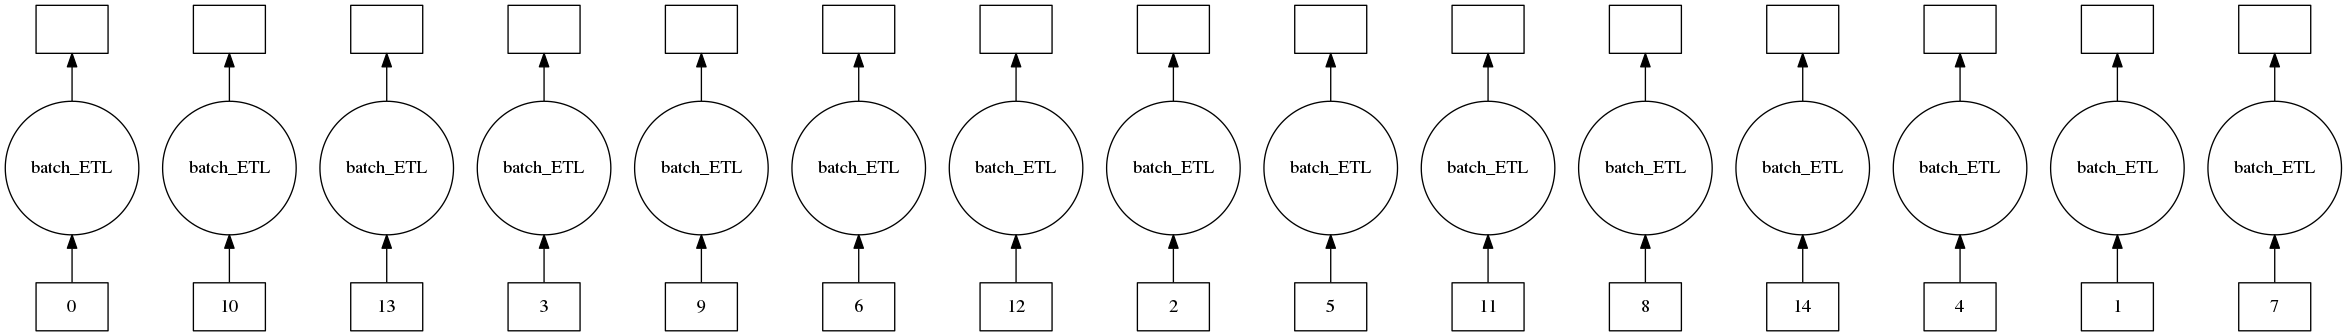

In [27]:
%%time
# a = dask.compute(delayed_records)
results = dask.compute(delayed_results)
dask.visualize(delayed_results)

In [30]:
# # resize_transform = partial(transform, target_shape=target_config.target_shape)
# delayed_results = []

# print(f"len(delayed_records)={len(delayed_records)}")
# for i, rec in enumerate(delayed_records):
#     result = batch_ETL(batch_records=[rec], target_shape=target_config.target_shape)
#     delayed_results.append(result)
#     print(result)
# #     break
#     print(i)
# print(delayed_results)

In [30]:
print(type(delayed_results), len(delayed_results))
print(delayed_results[0], type(delayed_results[0]), len(delayed_results))

dask.visualize(delayed_results[0])
delayed_results[0]

dask.visualize(delayed_results[0], filename='results.png')

r = dask.compute(delayed_results)

In [29]:
%%time
print(type(delayed_results), len(delayed_results))
print(delayed_results[0], type(delayed_results[0]), len(delayed_results))

results = dask.compute(*delayed_results)
print(type(results), len(results))

In [29]:
dask.visualize(delayed_results)

In [50]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
pp(file_list[:6])

Found 1884 files


[
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_0034
19.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_FLFO_006093A.jpg'
,
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_CU_0432.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_FLFO_004753.jpg
',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Caesalpinites_acuminatus_Florissant_FLFO_00663
1B.jpg'
]

idx = 163
/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Betulaceae/Betulaceae_Paracarpinus_fraterna_Florissant_FLFO_004894B.jpg


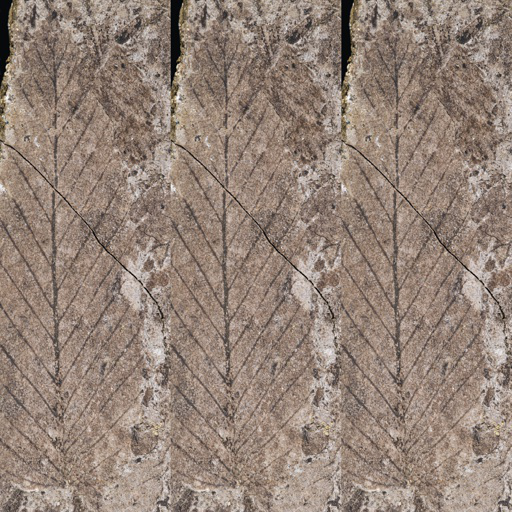

In [42]:
idx = random.sample(range(300),1)[0]
print(f"idx = {idx}")

path = file_list[idx]
print(path)
PIL.Image.open(path)

# PIL.Image.open('/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg')

idx = 232
/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Pinaceae/Pinaceae_Pinus_sp_Florissant_FLFO_004425B.jpg


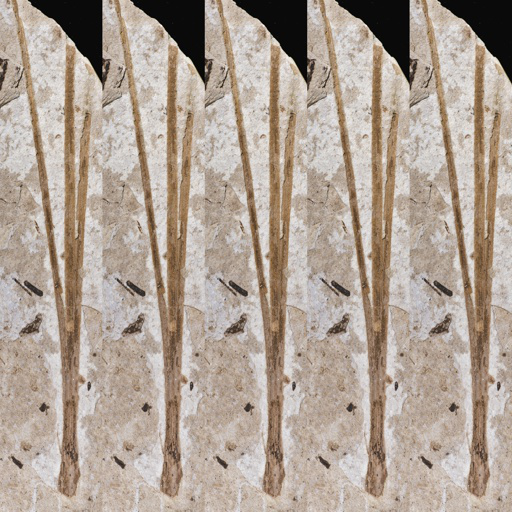

In [39]:
idx = random.sample(range(300),1)[0]
print(f"idx = {idx}")

path = file_list[idx]
print(path)
PIL.Image.open(path)

# PIL.Image.open('/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg')

#### Scratch pre

In [63]:
# results=results[0][0]#[0][0][0].shape

# len
# type(results[0]))#[0][0]#[0][0][0].shape

len(results[1])#[0])#[0]#[0][0]#[0][0][0].shape

1

In [30]:
resize_transform = partial(transform, target_shape=target_config.target_shape)

extracted, transformed, written = [], [], []

for i, rec in enumerate(delayed_records):
    extracted.append(dask.delayed(open_image)(row=rec))
    transformed.append(dask.delayed(resize_transform)(img=extracted, row=rec))
    written.append(dask.delayed(write_jpeg)(img=transformed, row=rec))
#     break
    print(i)
    
    
print(extracted, transformed, written)

# extracted
# transformed
# written

# extracted.visualize()
# transformed.visualize()
# written.visualize()



In [29]:
# step1 = dask.compute(extracted)
# step1

# step2 = dask.compute(transformed)
# step2

# transformed
# step2

step3 = dask.compute(written)

step3

In [44]:
# %%bash

file_list = !find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f
print(f"Found {len(file_list)} files")
pp(file_list[:6])

Found 10 files


[
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Caesalpinites_coloradicus_Florissant_FLFO_0034
19.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_FLFO_006093A.jpg'
,
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Cercis_parvifolia_Florissant_CU_0432.jpg',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_FLFO_004753.jpg
',
    '/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Fl
orissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Caesalpinites_acuminatus_Florissant_FLFO_00663
1B.jpg'
]

In [32]:
PIL.Image.open(file_list[1])

PIL.Image.open('/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg/Fabaceae/Fabaceae_Robinia_lesquereuxi_Florissant_CU_0101.jpg')

In [56]:
transformed

step2

In [25]:
# %%time

# task = ExtractTransformSave
# extracted = record_bag.map(task)

%%time

resize_transform = partial(transform, target_shape=target_config.target_shape)

# extracted = record_bag.map(open_pil) #(row: Dict[str,Any])
extracted = record_bag.map(open_image) #(row: Dict[str,Any])
transformed = extracted.map(resize_transform)#(img: PIL.Image, row: Dict[str,Any]=None, target_shape: Optional[Tuple[int]]=None ) -> np.ndarray:
written = transformed.map(write_jpeg) #(img: torch.Tensor, row: Dict[str,Any]) -> bool:


# written.visualize("vis.png")
# extracted.visualize()
transformed.visualize()
# %%time

# a.compute();



# a= extracted.take(3,10)

a= transformed.take(3,10)

client.get_versions(check=True)

len(a)

a[2].shape

b = a.compute()
b

b[0].shape

type(b[0])

extracted



out = extracted.compute();
print(type(out))
out


row = record_bag.compute()[0]
row

plt.imshow(PIL.Image.open(row['path']))

plt.imshow(out[0][:,:,::-1])

type(out[0])

a = record_bag.to_dataframe()#.visualize('count_florissant_fossils_graph.png')#compute()
a

b = a.compute()
b

record_bag.count().visualize('count_florissant_fossils_graph.png')#compute()

In [19]:
task = ExtractTransformSave
arrays = [task(rec) for rec in records]
print(len(arrays), arrays[:5])

print(len(arrays))
n = len(arrays)
a = [da.from_delayed(element, shape=(3,512,512), dtype='uint8') for element in arrays[:5]]

a#rrays[:5]

a = da.stack(a)

a

# a.visualize()

b = dask.compute(*a)
b

len(b)

type(b[0])

c = dask.compute(*b)
c




(sum(a[0,...] - a[1,...])).compute()

img = a[1,...].compute()

In [19]:
from_delayed(img

img.compute()

stacked = da.stack(da.from_delayed(arrays, shape=(1,)))

out = client.compute(arrays)
out



In [13]:
records = data_df.to_dict("records")

task = DaskExtract.ExtractTransformSave
arrays = [task(dask.delayed(rec)) for rec in records]

a = dask.compute(arrays[0])

# task

out = client.compute(arrays)
out

progress(out)

arrays[0].visualize()

da.from_delayed(a)

# len(a[0][1])
os.path.exists(Path(a[0][1][1][-1][1]).parent)

a = dask.compute(arrays[0])
a

%%time
# client=Client()

# inputs = dask.delayed(data_df)

arrays = dask_map_tasks(task=DaskExtract.ExtractTransformSave,
                        inputs=data_df,
                        config=config)

progress(arrays)

arrays[:5].visualize()

dir(arrays[0])

arrays[0].visualize()

# a = arrays.presist
dir(arrays)

arrays.trace()

arrays.shape

# b = data_df.to_records()
# b[0]
# dir(data_df)

b = data_df.to_dict("records")

delayed_data = dask.delayed(data_df)
delayed_data

out = dd.from_delayed(delayed_data)
out

out.visualize()

delayed_data.persist()

# a = data_df.to_xarray()
# a

In [31]:
%%time
client=Client()

inputs = dask.delayed(data_df).path

arrays = dask_map_tasks(task=dask_ExtractTransform,
                        inputs=inputs,
                        config=config)


arrays

dask.visualize(arrays.blocks[0])
dask.visualize(arrays.blocks[1])
# arrays.blocks[0]

da.result_type(arrays)

dask.visualize(arrays)

# filenames = data_df.head(1000).path.tolist()
filenames = dd.from_pandas(data_df.head(1000).path, chunksize=100)
delayed_data = filenames.to_delayed()
# filenames
delayed_data

back_again = dd.from_delayed(delayed_data)
back_again

back_again_df = back_again.to_frame()
back_again_df

back_again_df.visualize()

result = back_again_df.compute()

result

report = performance_report(filename="dask-report.html")
arrays = filenames.map(dask_ExtractTransform)
    
arrays.compute()
#     arrays = filenames.map_partitions(task=dask_ExtractTransform,
#                                       inputs=filenames)

dd.from_delayed(arrays.partitions[0])

In [20]:
b = dd.from_delayed(arrays)



arrays.partitions[5].visualize()

# %%time

# from dask.distributed import performance_report
# # with performance_report(filename="dask-report.html"):


# def dask_map_tasks(task, inputs):
#     filenames.map_partitions(task, inputs)
#     lazy_arrays = [task(i) for i in inputs]
#     dask_arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8")
#                    for delayed_reader in lazy_arrays]
#     arrays = da.stack(dask_arrays)
#     return arrays

# print
dir(filenames)

filenames.map_partitions()



# filenames.npartitions
filenames.partitions[0].partitions[0].visualize()

%%time

# filenames = data_df.head(1000).path.tolist()
with performance_report(filename="dask-report.html"):
    filenames = dd.from_pandas(data_df.head(1000).path, chunksize=100)
    arrays = dask_map_tasks(task=dask_ExtractTransform,
                            inputs=filenames)

dask.visualize(arrays.partitions[:5],
               optimize_graph=True,
               color="order",
               cmap="autumn",
               node_attr={"penwidth": "4"})

%%time

filenames = data_df.head(1000).path.tolist()

# from dask.distributed import performance_report
# with performance_report(filename="dask-report.html"):
if True:
    print("Begin")
    lazy_arrays = [dask_ExtractTransform(fn) for fn in filenames]
    dask_arrays = [da.from_delayed(delayed_reader, shape=config.target_shape, dtype="uint8") #sample.dtype)
                   for delayed_reader in lazy_arrays]
    arrays = da.stack(dask_arrays)
    print('computing')
#     arrays = dask.compute(arrays)
    arrays = client.compute(arrays)
    print(arrays)#[0].shape)
    print('done')

progress(arrays)

# from ray.util.dask import RayDaskCallback
# from timeit import default_timer as timer


# class MyTimerCallback(RayDaskCallback):
#     def _ray_pretask(self, key, object_refs):
#         # Executed at the start of the Ray task.
#         start_time = timer()
#         return start_time

#     def _ray_posttask(self, key, result, pre_state):
#         # Executed at the end of the Ray task.
#         execution_time = timer() - pre_state
#         print(f"Execution time for task {key}: {execution_time}s")


dir(dask)

dir(dask.config)

In [23]:
dask.config.global_config



from concurrent.futures import ThreadPoolExecutor
with dask.config.set(pool=ThreadPoolExecutor(4)):
    x.compute()

with dask.config.set(num_workers=4):
    x.compute()

arrays = dask.compute(*lazy_arrays)

for a in arrays:
    print(a.shape)



lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]

persisted_arrays = dask.persist(*lazy_arrays)

# dask_arrays = [
#     da.from_delayed(delayed_reader, dtype="uint8") #sample.dtype)
#     for delayed_reader in lazy_arrays
# ]
# persisted_arrays

a = dask.compute(persisted_arrays[0])
a

# plt.imshow(np.transpose(a, (1,2,0)))
plt.imshow(a[0].squeeze())
           

In [ ]:
# results = samples_df.apply(lambda x: ray_LoadTransformWrite.remote(source_path=x.source,
#                                                                    target_path=x.target),
#                            axis=1)

# print(len(results), type(results))

# def split_df_into_chunks(data_df: pd.DataFrame, num_chunks: int) -> List[pd.DataFrame]:
#     idx_chunks = [list(idx) for idx in more_itertools.divide(num_chunks, range(len(data_df)))]
#     df_chunks = [data_df.iloc[idx,:] for idx in idx_chunks]
#     return df_chunks

# ####################################
# ####################################

# clever_crop = CleverCrop(target_shape=(3,config.resolution,config.resolution) )

# ####################################
# ####################################

# @ray.remote
# def ray_open_pil(path: str) -> PIL.Image:
#     return Image.open(path)

# @ray.remote
# def ray_transform(img: PIL.Image) -> torch.Tensor:
#     img = transforms.ToTensor()(img)
#     img = clever_crop(img)
#     return (img * 255.0).to(torch.uint8)

# @ray.remote
# def ray_write_jpeg(img: torch.Tensor,
#                    target_path: str) -> bool:
#     if os.path.isfile(target_path):
#         return True
#     try:
#         torchvision.io.write_jpeg(img,
#                                   target_path,
#                                   quality=100)
#     except Exception as e:
#         print(target_path, e)
#     return os.path.isfile(target_path)


# ####################################
# ####################################

# @ray.remote
# def ray_LoadTransformWrite(source_path: str,
#                            target_path: str):
#     img = ray_open_pil.remote(path=source_path)
#     img = ray_transform.remote(img=img)
#     img = ray_write_jpeg.remote(img=img,
#                                 target_path=target_path)

#     return img

### Count files

In [30]:
%%bash

find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512/full/jpg" -type f | wc -l

5


In [10]:
%%bash

find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f | wc -l

3276


In [11]:
%%bash

find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f | wc -l

3692


In [12]:
%%bash

find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f | wc -l

3821


In [23]:
%%bash

find "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512/full/jpg" -type f | wc -l

4418


### Image Supervisor

In [6]:
@ray.remote
class ImageSaver:
    
    def __init__(self, 
                 data: pd.DataFrame,
                 clever_crop_config, 
                 init_dirs: bool=True):
        
        self.data = data
        print(f'ImageSaver data index (min, max): {(np.min(data.index), np.max(data.index))}')
        print(f"Config: {clever_crop_config}")
        self.clever_crop_config = clever_crop_config
#         self.clever_crop = CleverCrop(**asdict(clever_crop_config))
        print('Attempting to force target_shape = (3,512,512)')
        self.clever_crop = CleverCrop(target_shape=(3,512,512) )#**asdict(clever_crop_config))
        pp(repr(self.clever_crop))
        if init_dirs:
            self.init_dirs()
        
    def init_dirs(self):
        
        assert np.all(self.data.columns == ["source", "target"])
#         self.data.target.apply(lambda x: os.makedirs(os.path.dirname(x), exist_ok=True))
        subdirs = list(set(self.data.target.apply(lambda x: os.path.dirname(x)).values))
        print(f"Target dirs to be made (if currently nonexistent): {len(subdirs)}")
        for s in subdirs:
            os.makedirs(s, exist_ok=True)        
    
    
    def resize_and_save_img(self,
                            source_path: Union[str, Path],
                            target_path: str=None):
#         if isinstance(source_path, pd.Series):
#             source_path, target_path = source_path.iloc[0], source_path.iloc[1]
#             print(f'source: {source_path}, target: {target_path}')
        if os.path.isfile(target_path):
            return
        
        img = Image.open(source_path)
        img = transforms.ToTensor()(img)
        target_img = self.clever_crop(img)
        target_img = (target_img * 255.0).to(torch.uint8)
        try:
            torchvision.io.write_jpeg(target_img,
                                      target_path,
                                      quality=100)
        except Exception as e:
            print(target_path, e)
        assert os.path.isfile(target_path)
        
        
    def process_all(self):
        print(f'Initiating the saving of {len(self.data)} images from df rows')
        
        # Previously finished 3,172 images before changing the following line to .remote()
        
        self.data.apply(lambda x: self.resize_and_save_img.remote(x.source, x.target), axis=1)
#         self.data.apply(lambda x: self.resize_and_save_img(x.source, x.target), axis=1)
        print(f'FINISHED {len(self.data)}')
        
        return self.data.target_path.apply(os.path.isfile)
        
        
        
        

def resize_and_save_img(source_path: Union[str, Path],
                        target_path: str=None):
#         if isinstance(source_path, pd.Series):
#             source_path, target_path = source_path.iloc[0], source_path.iloc[1]
#             print(f'source: {source_path}, target: {target_path}')
    if os.path.isfile(target_path):
        return

    img = Image.open(source_path)
    img = transforms.ToTensor()(img)
    target_img = self.clever_crop(img)
    target_img = (target_img * 255.0).to(torch.uint8)
    try:
        torchvision.io.write_jpeg(target_img,
                                  target_path,
                                  quality=100)
    except Exception as e:
        print(target_path, e)
    assert os.path.isfile(target_path)
        
        
        
        
ImageSaver.remote(self.df_chunks[i], self.config) for i in range(self.num_workers)
        
        
from ray.util import ActorPool
@ray.remote
class ImageSupervisor:
    
    
    def __init__(self, data: pd.DataFrame, clever_crop_config, num_workers=1):
        self.config = clever_crop_config
        self.num_workers = num_workers
        
        self.data = data
        self.setup_workers()
        
    def setup_workers(self):
        
        self.df_chunks = split_df_into_chunks(data_df=self.data, num_chunks=self.num_workers)
        self.image_saver_pool = ActorPool(
                                [ImageSaver.remote(self.df_chunks[i], self.config) for i in range(self.num_workers)]
                                     )
#         self.image_savers = ActorPool(
#                                 [ImageSaver.remote(self.df_chunks[i], self.config) for i in range(self.num_workers)]
#                                      )
    
    def process_all(self):
        
#         results = [saver.process_all.remote() for saver in self.image_savers]
        results = list(self.image_saver_pool.map(lambda a, i: a.process_all.remote(), list(range(self.num_workers))))
        return results
        

In [8]:
res = 512
target_shape=(3, res, res)
# num_cpus = 4
# ray.init(num_cpus = num_cpus)
ccrop_config = CleverCropConfig(interp_method=interp_methods.cubic,
                                 antialiasing=True,
                                 target_shape=target_shape,
                                 max_aspect_ratio=1.2,
                                 grayscale=False,
                                 normalize=True)
# clever_crop = CleverCrop(**asdict(ccrop_config))
# image_saver = ImageSaver.remote(ccrop_config)

supervisor = ImageSupervisor.remote(data=data_df,
                                    clever_crop_config=ccrop_config,
                                    num_workers=num_cpus)
results = supervisor.process_all.remote()

results

In [ ]:


results

In [11]:
supervisor

output = ray.get(results)
output

In [9]:
supervisor

output

In [ ]:
%%bash



rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/512" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1024" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/1536" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/2048" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Extant_Leaves/128" &

rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/512" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1024" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/1536" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/General_Fossil/2048"

rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/512" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/1024" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/1536" &
rm -rfv "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v1_0/images/Fossil/Florissant_Fossil/2048"

In [61]:
source_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/tests/test_images/tall_aspect_ratio_leaf_image.jpg"
target_path = "/media/data/jacob/GitHub/lightning-hydra-classifiers/tests/test_images/tall_aspect_ratio_leaf_image-resized.jpg"


obj = image_saver.resize_and_save_img.remote(source_path,
                                       target_path)

(pid=18728) Aspect Ratio = 1.71 > max_aspect_ratio = 1.2, stacking.


In [64]:
ray.get(obj)